# **Imports**


Montage de Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from google.colab import files

In [3]:
def load_CIRFA10(batch_size):

  PATH = '/content/drive/My Drive/Colab_sources/data'
  transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

  transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

  trainset = torchvision.datasets.CIFAR10(root=PATH, train=True,
                                            download=False, transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root=PATH, train=False,
                                           download=False, transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

  classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return trainloader, testloader, classes

# **Dataset & Réseau**

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


##**Réseau de neurones**

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.root = Root(2*out_channels, out_channels)
        if level == 1:
            self.left_tree = block(in_channels, out_channels, stride=stride)
            self.right_tree = block(out_channels, out_channels, stride=1)
        else:
            self.left_tree = Tree(block, in_channels,
                                  out_channels, level=level-1, stride=stride)
            self.right_tree = Tree(block, out_channels,
                                   out_channels, level=level-1, stride=1)

    def forward(self, x):
        out1 = self.left_tree(x)
        out2 = self.right_tree(out1)
        out = self.root([out1, out2])
        return out


class SimpleDLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(SimpleDLA, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
net = SimpleDLA().to(device)
pretrained_model = '/content/drive/My Drive/Colab_sources/lib/parameters_91.pth'
net.load_state_dict(torch.load(
    pretrained_model, map_location=torch.device(device)))
net.eval()

SimpleDLA(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Tree(
    (root): Root(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (left_tree): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride

##**Dataset**

In [7]:
batch_size=10

In [8]:
trainloader, testloader, classes = load_CIRFA10(batch_size)

In [9]:
def new_testloader(model):
    l=[]
    n=0
    for _,(datas, labels) in enumerate(testloader):
        datas, labels=datas.to(device), labels.to(device)
        list_tf=(model(datas).max(dim=1)[1] == labels)
        n=n+list_tf.sum().item()
        l.append((datas[list_tf], labels[list_tf]))
    return n,l

In [10]:
n_testloader2,testloader2=new_testloader(net)

#**Attaques**

##**Gradient**

###**FGSM**

In [11]:
def fgsm_attack(model, data, label, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(data, requires_grad=True)
    loss = F.nll_loss(model(data + delta), label)
    loss.backward()
    return torch.clamp(data+epsilon * delta.grad.detach().sign(), -1, 1)

###**PGD Linf**

In [12]:
def pgd_linf(model, data, label, epsilon, alpha, num_iter):
    """ Construct PGD adversarial examples on the samples X"""
    delta = torch.zeros_like(data, requires_grad=True)
    for t in range(num_iter):
        loss = F.nll_loss(model((data + delta).clamp(-1, 1)), label)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()
                      ).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return (data+delta).clamp(-1, 1).detach()

###**PGD Linf random restart**

In [13]:
def pgd_linf_rand(model, data, label, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(label.shape[0]).to(device)
    max_delta = torch.zeros_like(data)

    for i in range(restarts):
        delta = torch.rand_like(data, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon

        for t in range(num_iter):
            loss = F.nll_loss(model((data + delta).clamp(-1, 1)), label)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()
                          ).clamp(-epsilon, epsilon)
            delta.grad.zero_()

        all_loss = nn.CrossEntropyLoss(
            reduction='none')(model(data+delta), label)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return (data + max_delta).clamp(-1, 1)

##**Square Attack**

###**Fonctions annexes**

In [14]:
np.set_printoptions(precision=5, suppress=True)


def p_selection(p_init, it, n_iters):
    """ Piece-wise constant schedule for p (the fraction of pixels changed on every iteration). """
    it = int(it / n_iters * 10000)

    if 10 < it <= 50:
        p = p_init / 2
    elif 50 < it <= 200:
        p = p_init / 4
    elif 200 < it <= 500:
        p = p_init / 8
    elif 500 < it <= 1000:
        p = p_init / 16
    elif 1000 < it <= 2000:
        p = p_init / 32
    elif 2000 < it <= 4000:
        p = p_init / 64
    elif 4000 < it <= 6000:
        p = p_init / 128
    elif 6000 < it <= 8000:
        p = p_init / 256
    elif 8000 < it <= 10000:
        p = p_init / 512
    else:
        p = p_init

    return p


def pseudo_gaussian_pert_rectangles(x, y):
    delta = np.zeros([x, y])
    x_c, y_c = x // 2 + 1, y // 2 + 1

    counter2 = [x_c - 1, y_c - 1]
    for counter in range(0, max(x_c, y_c)):
        delta[max(counter2[0], 0):min(counter2[0] + (2 * counter + 1), x),
              max(0, counter2[1]):min(counter2[1] + (2 * counter + 1), y)] += 1.0 / (counter + 1) ** 2

        counter2[0] -= 1
        counter2[1] -= 1

    delta /= np.sqrt(np.sum(delta ** 2, keepdims=True))

    return delta


def meta_pseudo_gaussian_pert(s):
    delta = np.zeros([s, s])
    n_subsquares = 2
    if n_subsquares == 2:
        delta[:s // 2] = pseudo_gaussian_pert_rectangles(s // 2, s)
        delta[s // 2:] = pseudo_gaussian_pert_rectangles(s - s // 2, s) * (-1)
        delta /= np.sqrt(np.sum(delta ** 2, keepdims=True))
        if np.random.rand(1) > 0.5:
            delta = np.transpose(delta)

    elif n_subsquares == 4:
        delta[:s // 2, :s // 2] = pseudo_gaussian_pert_rectangles(
            s // 2, s // 2) * np.random.choice([-1, 1])
        delta[s // 2:, :s // 2] = pseudo_gaussian_pert_rectangles(
            s - s // 2, s // 2) * np.random.choice([-1, 1])
        delta[:s // 2, s // 2:] = pseudo_gaussian_pert_rectangles(
            s // 2, s - s // 2) * np.random.choice([-1, 1])
        delta[s // 2:, s // 2:] = pseudo_gaussian_pert_rectangles(
            s - s // 2, s - s // 2) * np.random.choice([-1, 1])
        delta /= np.sqrt(np.sum(delta ** 2, keepdims=True))

    return delta


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)


def loss_f(label, res, loss_type="margin_loss"):
    """ Implements the margin loss (difference between the correct and 2nd best class). """
    if loss_type == "margin_loss":
        a = res-res[np.arange(label.shape[0]), label][:, None]
        a[np.arange(label.shape[0]), label] = np.inf
        return (-1*torch.min(a, dim=1)[0]).to('cpu').detach().numpy()
    else:
        return nn.CrossEntropyLoss(reduce=False)(res, label).to('cpu').detach().numpy()




###**L2**

In [15]:
def square_attack_l2(net, data, label, eps, n_iters, p_init, loss_type):
    model = net
    x = data.to('cpu').detach().numpy()
    y = label.to('cpu').detach().numpy()

    """ The L2 square attack """
    np.random.seed(0)

    min_val, max_val = -1, 1
    c, h, w = x.shape[1:]
    n_features = c * h * w

    # initialization
    delta_init = np.zeros(x.shape)
    s = h // 5
    sp_init = (h - s * 5) // 2
    center_h = sp_init + 0
    for counter in range(h // s):
        center_w = sp_init + 0
        for counter2 in range(w // s):
            delta_init[:, :, center_h:center_h + s, center_w:center_w + s] += meta_pseudo_gaussian_pert(s).reshape(
                [1, 1, s, s]) * np.random.choice([-1, 1], size=[x.shape[0], c, 1, 1])
            center_w += s
        center_h += s
    delta_init[0].squeeze().shape

    x_best = np.clip(x + delta_init / np.sqrt(np.sum(delta_init **
                                                     2, axis=(1, 2, 3), keepdims=True)) * eps, 0, 1)

    logits = model(torch.tensor(x_best, dtype=torch.float32).to(device))
    loss_min = loss_f(label, logits, loss_type=loss_type)
    margin_min = loss_f(label, logits, loss_type='margin_loss')

    # ones because we have already used 1 query
    n_queries = np.ones(x.shape[0])

    for i_iter in range(n_iters):
        idx_to_fool = (margin_min > 0.0)

        x_curr, x_best_curr = x[idx_to_fool], x_best[idx_to_fool]
        y_curr, margin_min_curr = y[idx_to_fool], margin_min[idx_to_fool]
        loss_min_curr = loss_min[idx_to_fool]
        delta_curr = x_best_curr - x_curr

        p = p_selection(p_init, i_iter, n_iters)
        s = max(int(round(np.sqrt(p * n_features / c))), 3)

        if s % 2 == 0:
            s += 1

        s2 = s + 0
        # window_1
        center_h = np.random.randint(0, h - s)
        center_w = np.random.randint(0, w - s)
        new_deltas_mask = np.zeros(x_curr.shape)
        new_deltas_mask[:, :, center_h:center_h +
                        s, center_w:center_w + s] = 1.0

        # window_2
        center_h_2 = np.random.randint(0, h - s2)
        center_w_2 = np.random.randint(0, w - s2)
        new_deltas_mask_2 = np.zeros(x_curr.shape)
        new_deltas_mask_2[:, :, center_h_2:center_h_2 +
                          s2, center_w_2:center_w_2 + s2] = 1.0

        # compute total norm available
        curr_norms_window = np.sqrt(
            np.sum(((x_best_curr - x_curr) * new_deltas_mask) ** 2, axis=(2, 3), keepdims=True))
        curr_norms_image = np.sqrt(
            np.sum((x_best_curr - x_curr) ** 2, axis=(1, 2, 3), keepdims=True))
        mask_2 = np.maximum(new_deltas_mask, new_deltas_mask_2)
        norms_windows = np.sqrt(
            np.sum((delta_curr * mask_2) ** 2, axis=(2, 3), keepdims=True))

        # create the updates
        new_deltas = np.ones([x_curr.shape[0], c, s, s])
        new_deltas = new_deltas * \
            meta_pseudo_gaussian_pert(s).reshape([1, 1, s, s])
        new_deltas *= np.random.choice([-1, 1],
                                       size=[x_curr.shape[0], c, 1, 1])
        old_deltas = delta_curr[:, :, center_h:center_h + s,
                                center_w:center_w + s] / (1e-10 + curr_norms_window)
        new_deltas += old_deltas
        new_deltas = new_deltas / np.sqrt(np.sum(new_deltas ** 2, axis=(2, 3), keepdims=True)) * (
            np.maximum(eps ** 2 - curr_norms_image ** 2, 0) / c + norms_windows ** 2) ** 0.5
        delta_curr[:, :, center_h_2:center_h_2 + s2,
                   center_w_2:center_w_2 + s2] = 0.0  # set window_2 to 0
        delta_curr[:, :, center_h:center_h + s,
                   center_w:center_w + s] = new_deltas + 0  # update window_1

        x_new = x_curr + delta_curr / \
            np.sqrt(np.sum(delta_curr ** 2, axis=(1, 2, 3), keepdims=True)) * eps
        x_new = np.clip(x_new, min_val, max_val)
        curr_norms_image = np.sqrt(
            np.sum((x_new - x_curr) ** 2, axis=(1, 2, 3), keepdims=True))

        logits = model(torch.tensor(x_new, dtype=torch.float32).to(device))
        loss = loss_f(torch.tensor(y_curr).to(
            device), logits, loss_type=loss_type)
        margin = loss_f(torch.tensor(y_curr).to(device),
                        logits, loss_type='margin_loss')

        idx_improved = loss < loss_min_curr
        loss_min[idx_to_fool] = idx_improved * \
            loss + ~idx_improved * loss_min_curr
        margin_min[idx_to_fool] = idx_improved * \
            margin + ~idx_improved * margin_min_curr

        idx_improved = np.reshape(idx_improved, [-1, *[1] * len(x.shape[:-1])])
        x_best[idx_to_fool] = idx_improved * \
            x_new + ~idx_improved * x_best_curr
        n_queries[idx_to_fool] += 1
    return n_queries, torch.tensor(x_best, dtype=torch.float32).to(device)

###**L_inf**

In [16]:
def square_attack_linf(model, data, label, eps, n_iters, p_init, loss_type):
    x = data.to('cpu').detach().numpy()
    y = label.to('cpu').detach().numpy()
    """ The Linf square attack """
    np.random.seed(0)  # important to leave it here as well
    min_val, max_val = -1, 1
    c, h, w = x.shape[1:]
    n_features = c*h*w

    # [c, 1, w], i.e. vertical stripes work best for untargeted attacks
    init_delta = np.random.choice([-eps, eps], size=[x.shape[0], c, 1, w])
    x_best = np.clip(x + init_delta, min_val, max_val)

    logits = model(torch.tensor(x_best, dtype=torch.float32).to(device))
    loss_min = loss_f(label, logits,  loss_type=loss_type)
    margin_min = loss_f(label, logits,  loss_type='margin_loss')
    # ones because we have already used 1 query
    n_queries = np.ones(x.shape[0])

    for i_iter in range(n_iters - 1):
        idx_to_fool = margin_min > 0
        x_curr, x_best_curr, y_curr = x[idx_to_fool], x_best[idx_to_fool], y[idx_to_fool]
        loss_min_curr, margin_min_curr = loss_min[idx_to_fool], margin_min[idx_to_fool]
        deltas = x_best_curr - x_curr

        p = p_selection(p_init, i_iter, n_iters)
        for i_img in range(x_best_curr.shape[0]):
            s = int(round(np.sqrt(p * n_features / c)))
            # at least c x 1 x 1 window is taken and at most c x h-1 x h-1
            s = min(max(s, 1), h-1)
            center_h = np.random.randint(0, h - s)
            center_w = np.random.randint(0, w - s)

            x_curr_window = x_curr[i_img, :,
                                   center_h:center_h+s, center_w:center_w+s]
            x_best_curr_window = x_best_curr[i_img, :,
                                             center_h:center_h+s, center_w:center_w+s]
            # prevent trying out a delta if it doesn't change x_curr (e.g. an overlapping patch)
            count=0
            while np.sum(np.abs(np.clip(x_curr_window + deltas[i_img, :, center_h:center_h+s, center_w:center_w+s], min_val, max_val) - x_best_curr_window) < 10**-7) == c*s*s:
                deltas[i_img, :, center_h:center_h+s, center_w:center_w +
                       s] = np.random.choice([-eps, eps], size=[c, 1, 1])
                count=count+1
                if count >10:
                    break

        x_new = np.clip(x_curr + deltas, min_val, max_val)

        logits = model(torch.tensor(x_new, dtype=torch.float32).to(device))

        loss = loss_f(torch.tensor(y_curr).to(device),
                      logits,  loss_type=loss_type)
        margin = loss_f(torch.tensor(y_curr).to(device),
                        logits,  loss_type='margin_loss')

        idx_improved = loss < loss_min_curr
        loss_min[idx_to_fool] = idx_improved * \
            loss + ~idx_improved * loss_min_curr
        margin_min[idx_to_fool] = idx_improved * \
            margin + ~idx_improved * margin_min_curr
        idx_improved = np.reshape(idx_improved, [-1, *[1]*len(x.shape[:-1])])
        x_best[idx_to_fool] = idx_improved * \
            x_new + ~idx_improved * x_best_curr
        n_queries[idx_to_fool] += 1

    return n_queries, torch.tensor(x_best, dtype=torch.float32).to(device)

# **Performances**

In [17]:
l_eps=[2/255,4/255,8/255,16/255]

##**Performance réseau de neuronnes**

In [ ]:
def performance(batch_size, model):
    n_attack = 0
    for i,(datas, labels) in enumerate(testloader):
        datas, labels=datas.to(device), labels.to(device)
        n_attack = n_attack + \
            (model(datas).max(dim=1)[1] != labels).sum().item()
        if i==0:
            print("Start !")
        if ((i+1)*batch_size) % 100 == 0:
            print(
                f"{(i+1)*batch_size} ème traité ! - {100*n_attack/((i+1)*batch_size)}")
    return n_attack/(len(testloader)*batch_size)

In [ ]:
performance(batch_size,net)

Start !
100 ème traité ! - 8.0
200 ème traité ! - 8.0
300 ème traité ! - 8.0
400 ème traité ! - 8.0
500 ème traité ! - 7.8
600 ème traité ! - 7.5
700 ème traité ! - 7.714285714285714
800 ème traité ! - 8.375
900 ème traité ! - 8.0
1000 ème traité ! - 8.3
1100 ème traité ! - 8.454545454545455
1200 ème traité ! - 8.666666666666666
1300 ème traité ! - 8.538461538461538
1400 ème traité ! - 8.714285714285714
1500 ème traité ! - 8.4
1600 ème traité ! - 8.375
1700 ème traité ! - 8.411764705882353
1800 ème traité ! - 8.444444444444445
1900 ème traité ! - 8.631578947368421
2000 ème traité ! - 8.75
2100 ème traité ! - 9.047619047619047
2200 ème traité ! - 9.318181818181818
2300 ème traité ! - 9.391304347826088
2400 ème traité ! - 9.375
2500 ème traité ! - 9.48
2600 ème traité ! - 9.5
2700 ème traité ! - 9.37037037037037
2800 ème traité ! - 9.321428571428571
2900 ème traité ! - 9.344827586206897
3000 ème traité ! - 9.233333333333333
3100 ème traité ! - 9.387096774193548
3200 ème traité ! - 9.3125

0.0936

## **Attaques PGD**

###**FGSM**

In [ ]:
def performance_fgsm(batch_size, model, eps):
    n_attack = 0
    for i,(datas, labels) in enumerate(testloader):
        datas, labels=datas.to(device), labels.to(device)
        x_attack = fgsm_attack(model, datas, labels, eps)
        n_attack = n_attack + \
            (model(x_attack).max(dim=1)[1] != labels).sum().item()
        if (i*batch_size) % 100 == 0:
            print(
                f"{(i+1)*batch_size} ème traité ! - {100*n_attack/((i+1)*batch_size)}")
    return n_attack/(len(testloader)*batch_size)

In [ ]:
performance_fgsm(batch_size, net, 2./255)

In [ ]:
def performance_fgsm_eps(batch_size, model, l_eps):
    l=[]
    for eps in l_eps:
        n_attack = 0
        for _,(datas, labels) in enumerate(testloader2):
            datas, labels=datas.to(device), labels.to(device)
            x_attack = fgsm_attack(model, datas, labels, eps)
            n_attack = n_attack + \
                (model(x_attack).max(dim=1)[1] != labels).sum().item()
        l.append((eps,n_attack/n_testloader2))
        print(f"{l[-1]} - ok !")
    return l

In [ ]:
performance_fgsm_eps(batch_size, net2, l_eps)

(0.00784313725490196, 0.15054898648648649) - ok !
(0.01568627450980392, 0.17947635135135134) - ok !
(0.03137254901960784, 0.24767736486486486) - ok !
(0.06274509803921569, 0.3811233108108108) - ok !


[(0.00784313725490196, 0.15054898648648649),
 (0.01568627450980392, 0.17947635135135134),
 (0.03137254901960784, 0.24767736486486486),
 (0.06274509803921569, 0.3811233108108108)]

FGSM
(0.00784313725490196, 0.18170785525154456) - ok !
(0.01568627450980392, 0.2409532215357458) - ok !
(0.03137254901960784, 0.32215357458075905) - ok !
(0.06274509803921569, 0.4060017652250662) - ok !

###**PGD l_inf**

In [ ]:
def performance_pgd_linf(batch_size, model, eps, alpha, num_iter):
    n_attack = 0
    n_handled=0
    for i, (datas, labels) in enumerate(testloader2):
        datas, labels=datas.to(device), labels.to(device)
        x_attack = pgd_linf(
            model, datas, labels, eps, alpha, num_iter)
        n_attack = n_attack + \
            (model(x_attack).max(dim=1)[1] != labels).sum().item()
        n_handled=n_handled+datas.shape[0]
        if i==0:
          print(f"Start !- {eps}")
        if (i+1) % (10*batch_size) == 0:
            print(
                f"{n_handled} ème traité ! - {100*n_attack/n_handled}")
    return n_attack/n_testloader2

In [ ]:
performance_pgd_linf(batch_size, net, 2./255, 2./(255*10), 15)

In [ ]:
def performance_pgd_linf_eps(batch_size, model, l_eps, num_iter):
    l=[]
    for eps in l_eps:
        alpha=eps/10
        l.append((eps,performance_pgd_linf(batch_size, net, eps, eps/10, num_iter)))
    return l

In [ ]:
performance_pgd_linf_eps(batch_size, net, [8/255,16/255], 15)

(0.00784313725490196, 0.2731685789938217) - ok !
(0.01568627450980392, 0.4355692850838482) - ok !
(0.03137254901960784, 0.6575463371579876),
 (0.06274509803921569, 0.8506178287731686)


###**PGD l_inf random**

In [18]:
def performance_pgd_linf_rand(batch_size, model, eps, alpha, num_iter,num_restart):
    n_attack = 0
    n_handled=0
    for i, (datas, labels) in enumerate(testloader2):
        datas, labels=datas.to(device), labels.to(device)
        x_attack = pgd_linf_rand(
            model, datas, labels, eps, alpha, num_iter, num_restart)
        n_attack = n_attack + \
            (model(x_attack).max(dim=1)[1] != labels).sum().item()
        n_handled=n_handled+datas.shape[0]
        if i==0:
          print(f"Start !- {eps}")
        if (i+1) % (10*batch_size) == 0:
            print(
                f"{n_handled} ème traité ! - {100*n_attack/n_handled}")
    return n_attack/n_testloader2

In [22]:
performance_pgd_linf_rand(batch_size, net, 16/255, 16/(255*7), 15,3)

Start !- 0.06274509803921569
917 ème traité ! - 86.1504907306434


KeyboardInterrupt: ignored

In [ ]:
def performance_pgd_linf_rand_eps(batch_size, model, l_eps, num_iter,num_restart):
    l=[]
    for eps in l_eps:
        alpha=eps/10
        l.append((eps,performance_pgd_linf_rand(batch_size, model, eps, alpha, num_iter,num_restart)))
    return l

In [ ]:
performance_pgd_linf_rand_eps(batch_size, net, l_eps,15,3)

Start !- 0.00784313725490196
917 ème traité ! - 26.172300981461287
1825 ème traité ! - 25.863013698630137
2723 ème traité ! - 26.441424899008446
3622 ème traité ! - 26.173384870237438
4519 ème traité ! - 26.24474441248064
5437 ème traité ! - 26.466801544969652
6342 ème traité ! - 26.63197729422895
7237 ème traité ! - 26.350697802957026
8149 ème traité ! - 26.05227635292674
9064 ème traité ! - 26.224624889673432
Start !- 0.01568627450980392
917 ème traité ! - 40.89422028353326
1825 ème traité ! - 40.43835616438356
2723 ème traité ! - 40.506793977231
3622 ème traité ! - 40.64053009387079
4519 ème traité ! - 40.56207125470237
5437 ème traité ! - 41.07044325915027
6342 ème traité ! - 41.343424787133394
7237 ème traité ! - 41.108194003039934
8149 ème traité ! - 41.23205301263959
9064 ème traité ! - 41.36142983230362
Start !- 0.03137254901960784
917 ème traité ! - 61.06870229007634
1825 ème traité ! - 62.3013698630137
2723 ème traité ! - 63.018729342636796
3622 ème traité ! - 62.838210933186

26.224624889673432
41.36142983230362
63.415710503089144
83.44582157319917

## **Square attacks**

###**L_inf**

In [32]:
def performance_square_attack_linf(batch_size, model, eps, n_iter, p, loss_type):
    n_attack = 0
    n_handled = 0
    for i, (datas, labels) in enumerate(testloader2):
        datas, labels = datas.to(device), labels.to(device)
        _, x_square_attack = square_attack_linf(
            model, datas, labels, eps, n_iter, p, loss_type)
        n_attack = n_attack + \
            (model(x_square_attack).max(dim=1)[1] != labels).sum().item()
        n_handled = n_handled + datas.shape[0]
        if i==0:
            print("Start !")
        if (i+1) % (10*batch_size) == 0:
            print(
                f"{n_handled} ème traité ! - {100*n_attack/n_handled}")
    return n_attack/n_testloader2

In [ ]:
performance_square_attack_linf(batch_size, net, 2/255, 15, 0.8, "margin_loss")

In [33]:
def performance_square_attack_linf_eps(batch_size, model, l_eps, n_iter, p, loss_type):
    l=[]
    for eps in l_eps:
        l.append((eps,performance_square_attack_linf(batch_size, model, eps, n_iter, p, loss_type)))
    return l

In [34]:
performance_square_attack_linf_eps(batch_size, net, l_eps, 15, 0.8, "margin_loss")

Start !
917 ème traité ! - 13.522355507088331
1825 ème traité ! - 12.657534246575343


KeyboardInterrupt: ignored

[(0.00784313725490196, 0.13349514563106796),
 (0.01568627450980392, 0.13879082082965577),
 (0.03137254901960784, 0.1507060900264784),
 (0.06274509803921569, 0.1820388349514563)]

###**L2**

In [ ]:
def performance_square_attack_l2(batch_size, model, eps, n_iter, p, loss_type):
    n_attack = 0
    n_handled = 0
    for i, (datas, labels) in enumerate(testloader):
        datas, labels = datas.to(device), labels.to(device)
        _, x_square_attack = square_attack_l2(
            model, datas, labels, eps, n_iter, p, loss_type)
        n_attack = n_attack + \
            (model(x_square_attack).max(dim=1)[1] != labels).sum().item()
        n_handled = n_handled + datas.shape[0]
        if i==0:
            print("Start !")
        if (i+1) % (10*batch_size) == 0:
            print(
                f"{n_handled} ème traité ! - {100*n_attack/n_handled}")
    return n_attack/n_testloader2

In [ ]:
performance_square_attack_l2(batch_size, net, 2/255, 15, 0.8, "loss_type")

In [ ]:
def performance_square_attack_l2_eps(batch_size, model, l_eps, n_iter, p, loss_type):
    l=[]
    for eps in l_eps:
        l.append((eps,performance_square_attack_l2(batch_size, model, eps, n_iter, p, loss_type)))
    return l

In [ ]:
performance_square_attack_l2_eps(batch_size, net, l_eps, 15, 0.8, "margin_loss")

Start !
1000 ème traité ! - 49.1
2000 ème traité ! - 49.05
3000 ème traité ! - 48.6
4000 ème traité ! - 48.425
5000 ème traité ! - 48.52
6000 ème traité ! - 48.833333333333336
7000 ème traité ! - 48.857142857142854
8000 ème traité ! - 48.7625
9000 ème traité ! - 48.888888888888886
10000 ème traité ! - 49.17
Start !
1000 ème traité ! - 49.1
2000 ème traité ! - 49.05
3000 ème traité ! - 48.6
4000 ème traité ! - 48.45
5000 ème traité ! - 48.54
6000 ème traité ! - 48.85
7000 ème traité ! - 48.871428571428574
8000 ème traité ! - 48.775
9000 ème traité ! - 48.9
10000 ème traité ! - 49.18
Start !
1000 ème traité ! - 49.1
2000 ème traité ! - 49.05
3000 ème traité ! - 48.63333333333333
4000 ème traité ! - 48.475
5000 ème traité ! - 48.54
6000 ème traité ! - 48.85
7000 ème traité ! - 48.871428571428574
8000 ème traité ! - 48.775
9000 ème traité ! - 48.9
10000 ème traité ! - 49.18
Start !
1000 ème traité ! - 49.1
2000 ème traité ! - 49.05
3000 ème traité ! - 48.6
4000 ème traité ! - 48.45
5000 èm

[(0.00784313725490196, 0.5424757281553398),
 (0.01568627450980392, 0.5425860547219771),
 (0.03137254901960784, 0.5425860547219771),
 (0.06274509803921569, 0.5424757281553398)]

[(0.00784313725490196, 0.5424757281553398),
 (0.01568627450980392, 0.5425860547219771),
 (0.03137254901960784, 0.5425860547219771),
 (0.06274509803921569, 0.5424757281553398)]

#**Visualisation**

###***Data***

In [26]:
data,label=testloader2[0]

In [27]:
data,label=data.to(device),label.to(device)

In [ ]:
def unnormalize(img):
    return np.clip(img.copy()/5+0.5,0,1) #Transformation valable uniquement pour testloader !


def truncate(number, digits):
    stepper = 10 ** digits
    return int(stepper * number) / stepper

def show_tensor(data):
    plt.imshow(unnormalize(
        data.squeeze().to('cpu').detach().numpy()).transpose((1, 2, 0)))
    plt.axis('off')
    return plt.show()

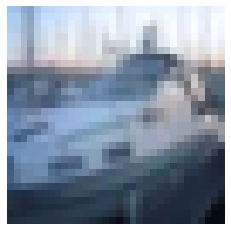

In [ ]:
show_tensor(data[2])

###**PGD(epsilon) : images**

In [ ]:
def visualisation_PGD_epsilon(model, data, label, l_epsilon, num_iter):
    l_data_attack = []
    for epsilon in l_epsilon:
        data_attack = attacks_PGD.pgd_linf(
            model, data, label, epsilon, epsilon, num_iter)
        l_data_attack.append(data_attack)

    for i in range(len(l_data_attack)):
        plt.subplot(1+len(l_data_attack)//5, 5, i+1)
        plt.imshow(unnormalize(
            l_data_attack[i][0].squeeze().detach().cpu().numpy()).transpose((1, 2, 0)))
        plt.title(f"Ɛ={truncate(l_epsilon[i],4)}/{int(l_epsilon[i]*255)}")
        plt.axis('off')
    plt.suptitle(
        f"PGD adversial attack with alpha=epsilon, num_iter={num_iter}")
    plt.savefig("image.png")
    return plt.show()

In [ ]:
visualisation_PGD_epsilon(net, data, label, [
                      float(i)/255 for i in range(0, 20)], 10)

In [ ]:

files.download("image.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###**PGD(num_iter)**

In [ ]:
def visualisation_PGD_num_iter(model, data, label, epsilon, alpha, l_num_iter):
    l_data_attack = []
    for num_iter in l_num_iter:
        data_attack = attacks_PGD.pgd_linf(
            model, data, label, epsilon, alpha, num_iter)
        l_data_attack.append(F.nll_loss(
              model(data_attack), label).item())

      plt.plot(l_num_iter, l_data_attack)
    plt.xlabel("Number of iterations")
    plt.ylabel("Null loss")
    plt.suptitle(
        f"PGD(l_inf) adversial attack with Ɛ={truncate(epsilon,4)}, α={truncate(alpha,4)}")
    plt.savefig("image.png")
    return plt.show()

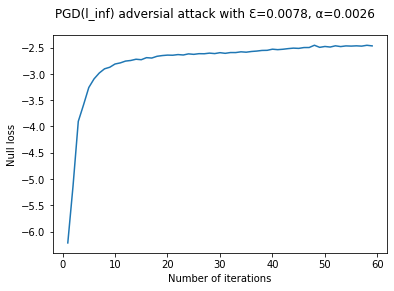

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
visualisation_PGD_num_iter(net, data, label, 2/255, 2/(255*3), [
        i for i in range(1, 60)])
files.download("image.png")

In [ ]:
def visualisation_PGD_alpha(model, data, label, epsilon, l_alpha, num_iter):
    l_data_attack = []
    for alpha in l_alpha:
        data_attack = attacks_PGD.pgd_linf(
            model, data, label, epsilon, alpha, num_iter)
        l_data_attack.append(F.nll_loss(
            model(data_attack), label).item())

    plt.plot([int(7./(255*i)) for i in l_alpha], l_data_attack)
    plt.xlabel("Ɛ/α")
    plt.ylabel("Null loss")
    plt.suptitle(
        f"PGD(l_inf) adversial attack with Ɛ={truncate(epsilon,4)}, num_iter={num_iter}")
    plt.savefig("image.png")
    return plt.show()

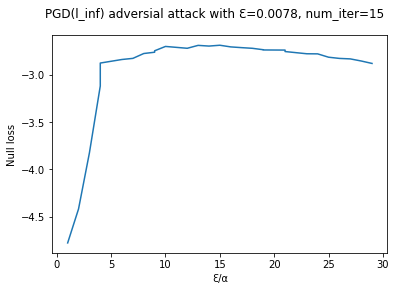

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
visualisation_PGD_alpha(net, data, label, 2/255,
                            [7./(255*i) for i in range(1, 30)], 15)
files.download("image.png")

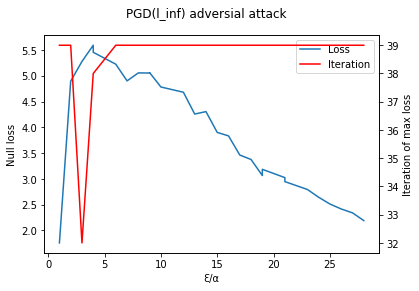

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
visualisation_PGD_alpha_num_iter(
        net, data, label, 7./255, [7./(255*i) for i in range(1, 29)], [i for i in range(20, 40)])
files.download("image.png")

##**Square attack**

In [28]:
def visualisation_square_attack_num_iter(model, data, label, l_num_iter):
    l_data_attack = []
    for num_iter in l_num_iter:
        _, data_attack = square_attack_linf(
            net, data, label, 16/255, num_iter, 0.8, "margin_loss")
        l_data_attack.append(F.nll_loss(
            model(data_attack), label).item())

    plt.plot(l_num_iter, l_data_attack)
    plt.xlabel("Number of iterations")
    plt.ylabel("Null loss")
    plt.suptitle(
        f"Square Attack Linf adversial attack")
    return plt.show()

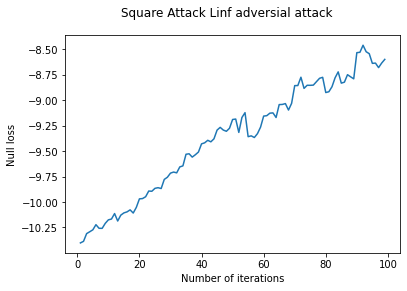

In [30]:
visualisation_square_attack_num_iter(net, data, label, range(1,100))

# **Téléchargement**

Télécherger paramètres du réseau

In [ ]:
PATH='/content/drive/My Drive/Colab_sources/Results/dwl.pth'
torch.save(net.state_dict(), PATH)



Téléchargement du modèle sur l'ordinateur

In [ ]:
torch.save(net.state_dict(), 'model.pth')

# download checkpoint file
files.download('model.pth')